In [26]:
''' 
Notebook that takes the splittet data from "Split_data.ipynb" and model the data using CNN layers for both sequential input.
Thus DS34, DS1234 and DS134 and DS234 are being processed in this notebook
Output: RMSE on the testsets exported for visualization in "Figures.ipynb"

'''


import sys, os
sys.path.append('../src/insulin_pk/utils/') 
import pickle  
import torch
import optuna
import random
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
import warnings
from torch import nn
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from itertools import repeat, chain
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import GroupKFold,GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
import seaborn as sns
import shap
# Import own modules:
from utils import *
# Supress optuna outputs and torch userwarnings
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore", category=UserWarning)

# Set seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
# Load full data (for SHAP analysis)
Full_data = pd.read_csv("../data/processed/full_data_set.csv")
Full_data.set_index("nncno",inplace=True)
## Load data in folds and select only relevant descriptorset:
DS12_folds = pickle.load(open('../data/processed/Data_folds.pkl','rb'))
DS1_folds = pickle.load(open('../data/processed/Data_folds.pkl','rb'))
DS2_folds = pickle.load(open('../data/processed/Data_folds.pkl','rb'))
DS4_folds = pickle.load(open('../data/processed/Data_folds.pkl','rb'))
DS3_folds = pickle.load(open('../data/processed/Data_folds.pkl','rb'))


for i in range(len(DS4_folds)):
    for j in range(3):
        DS12_folds[i][j] = contruct_descriptor_sets(DS12_folds[i][j],pd.Series("12"))
        DS1_folds[i][j] = contruct_descriptor_sets(DS1_folds[i][j],pd.Series("1"))
        DS2_folds[i][j] = contruct_descriptor_sets(DS2_folds[i][j],pd.Series("2"))
        DS3_folds[i][j] = contruct_descriptor_sets(DS3_folds[i][j],pd.Series("3"))
        DS4_folds[i][j] = contruct_descriptor_sets(DS4_folds[i][j],pd.Series("4"))
        

PK_names = ['CL[ml/min/kg]', 'T1/2[h]', 'MRT[h]']

# Set training/validation epochs and number of bayesian optimization rounds
EPOCH = 200
N_TRIALS = 30

# DS1234 using ANN

In [ ]:
# Loop over test folds DS1234
CV_folds_test_vivo = {}
for i in range(len(DS12_folds)): 
    print("=================BEGINNING FOLD {0} ==============".format(i+1))
    X_train, Y_train = DS12_folds[i][0].astype(np.float64),DS12_folds[i][3].astype(np.float32)  
    X_val,Y_val = DS12_folds[i][1].astype(np.float64),DS12_folds[i][4].astype(np.float32)
    X_test,Y_test = DS12_folds[i][2].astype(np.float64),DS12_folds[i][5].astype(np.float32)
    scaler_Y = pickle.load(open('../data/processed/Scaler_Y_{0}.pkl'.format(i),'rb'))
    
    X_train_seq = DS3_folds[i][0].astype(np.float64)
    X_train_seq.set_index(X_train.index,inplace = True)
    X_val_seq = DS3_folds[i][1].astype(np.float64)
    X_val_seq.set_index(X_val.index,inplace = True)
    X_test_seq = DS3_folds[i][2].astype(np.float64)
    X_test_seq.set_index(X_test.index,inplace = True)
    
    X_train_smiles = DS4_folds[i][0].astype(np.float64)
    X_train_smiles.set_index(X_train.index,inplace = True)
    X_val_smiles = DS4_folds[i][1].astype(np.float64)
    X_val_smiles.set_index(X_val.index,inplace = True)
    X_test_smiles = DS4_folds[i][2].astype(np.float64)
    X_test_smiles.set_index(X_test.index,inplace = True)
    
    dataset_train = Dataset_all_conc(X_train,X_train_seq,X_train_smiles,Y_train)
    dataset_val = Dataset_all_conc(X_val,X_val_seq,X_val_smiles,Y_val)
    dataset_test = Dataset_all_conc(X_test,X_test_seq,X_test_smiles,Y_test)
    
    # Hyper parameter optimization.
    study = optuna.create_study(direction="minimize",pruner=optuna.pruners.MedianPruner())
    study.optimize(lambda trial:objective_DS1234(trial,Data_train = dataset_train ,Data_Val = dataset_val ,
                                              Scaler_Y= scaler_Y,EPOCH=EPOCH,save_model=True,save_path = "../models/VIVO_FFNN_DS1234_fold{0}.pt".format(i+1),
                                              input_dim_desc = X_train.shape[1]),
                                              n_trials = N_TRIALS)
    trial_ = study.best_trial
    with open('../models/Optuna_DS1234_fold{0}.pkl'.format(i),'wb') as f:pickle.dump(trial_.params,f )
    print("Best hyperparameters for fold {0} is saved".format(i+1))
    print(f" best parameters for this fold {trial_.params}")
    best_params = pickle.load(open('../models/Optuna_DS1234_fold{0}.pkl'.format(i),'rb'))
    
    
    # Build model using best hyperparameters:
    
    model = model_DS1234_build(best_params,input_dim_desc = X_train.shape[1], X_length_DS3 = 1280,X_length_DS4 = 100,stride_CNN = 1,
                 conv_dilation1 = 1,padding_DS3 = 0,padding_DS4 = 0, max_pool_kernel_size3 = 4)
    #model.load_state_dict(torch.load("/home/kyei/Project1/Model files/VIVO_FFNN_DS1234_fold{0}.pt".format(i+1)))
    
    # Train model (again) on best hyperparameters for train/val diagnostic plots:
    Vivo_train_results = train_and_validate(Params = best_params,Model = model,Data_train = dataset_train ,Data_Val = dataset_val,
                                            scaler_Y = scaler_Y,EPOCH = EPOCH,save_model = True,save_path = "../models/VIVO_FFNN_DS1234_fold{0}.pt".format(i),
                                           trial = "None")
    
    
    # Make test set into dataloader:
    test_loader = DataLoader(dataset = dataset_test,batch_size=X_test.shape[0],shuffle=False,drop_last = True)
    
    # Use best model to evaluate on unseen test data:
    Vivo_test_results = test_FFNN(model,best_params, test_loader,scaler_Y = scaler_Y,save_path = "../models/VIVO_FFNN_DS1234_fold{0}.pt".format(i),Y_data_for_index = Y_test)
   
    # Save each individual test output for each fold:
    with open("../models/Test_output_DS1234_fold_{0}.pkl".format(i),'wb') as f:pickle.dump(Vivo_test_results,f )
    
    CV_folds_test_vivo[i] = Vivo_test_results
    
    model.apply(reset_weights)
    
with open("../data/processed/ANN_outer_5_test_DS1234.pkl",'wb') as f:pickle.dump(CV_folds_test_vivo,f )

print("Completely done")

# SHAP values for ANN DS1234

In [2]:
## Split the full dataset in 80% Training, 20% Test
Data_1234 = contruct_descriptor_sets(Full_data,pd.Series("DS1234"),with_PK = True)
X = Data_1234.drop(PK_names,axis=1)
Y = Data_1234[PK_names]
Y = np.log(Y)
train_inds, test_inds = next(GroupShuffleSplit(test_size=.2, n_splits=1, random_state = 42).split(X, groups=X.index.get_level_values("nncno")))
X_train = X.iloc[train_inds,:]
Y_train = Y.iloc[train_inds,:]
X_test = X.iloc[test_inds,:]
Y_test = Y.iloc[test_inds,:]
## Scale:
scaler_X = StandardScaler().fit(X_train)
scaler_Y = StandardScaler().fit(Y_train)
X_train_scaled = pd.DataFrame(scaler_X.transform(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler_X.transform(X_test),columns=X_test.columns)
Y_train_scaled = pd.DataFrame(scaler_Y.transform(Y_train),columns=Y_train.columns).astype(np.float32)
Y_test_scaled = pd.DataFrame(scaler_Y.transform(Y_test),columns=Y_test.columns).astype(np.float32)
# Split data into individual components:
X_train_DS4 =  X_train_scaled[X_train_scaled.columns[pd.Series(X_train_scaled.columns).str.startswith('DS4_')]].astype(np.float32)
X_test_DS4 =  X_test_scaled[X_test_scaled.columns[pd.Series(X_test_scaled.columns).str.startswith('DS4_')]].astype(np.float32)
X_train_DS3 =  X_train_scaled[X_train_scaled.columns[pd.Series(X_train_scaled.columns).str.startswith('DS3_')]].astype(np.float32)
X_test_DS3 =  X_test_scaled[X_test_scaled.columns[pd.Series(X_test_scaled.columns).str.startswith('DS3_')]].astype(np.float32)
X_train_DS12 = X_train_scaled.loc[:, X_train_scaled.columns.str.startswith("DS1") | X_train_scaled.columns.str.startswith("DS2")].astype(np.float32)
X_test_DS12 = X_test_scaled.loc[:, X_test_scaled.columns.str.startswith("DS1") | X_test_scaled.columns.str.startswith("DS2")].astype(np.float32) 
## Dataloaders:
dataset_train = Dataset_all_conc(X_train_DS12,X_train_DS3,X_train_DS4,Y_train_scaled)
dataset_test = Dataset_all_conc(X_test_DS12,X_test_DS3,X_test_DS4,Y_test_scaled)
# Make model and train using (median) best hyperparameters from nested CV:
best_params = {'lr': 0.001,
     'Batch_Size': 20,
     'wd': 0.001,
     'conv1_filters_DS3': 16,
     'conv2_filters_DS3': 32,
     'conv1_filters_DS4': 8,
     'conv2_filters_DS4': 16,
     'Kernel_size1_DS3': 7,
     'Kernel_size1_DS4': 7,
     'dropout_FFNN_DS3': 0.4,
     'dropout_CNN_DS3': 0.4,
     'dropout_CNN_DS4': 0.4,
     'FC_after_CNN_DS3': 200,
     'FC_after_CNN_DS4': 50,
     'FC_After_DS12': 20,
     'FC_Concatenation': 100}

Full_DS1234_model = model_DS1234_build(params = best_params, input_dim_desc = X_train_DS12.shape[1], X_length_DS3 = 1280,X_length_DS4 = 100,stride_CNN = 1,
                 conv_dilation1 = 1 ,padding_DS3 = 0 ,padding_DS4 = 0, max_pool_kernel_size3 = 3)

In [91]:
#DS1234_train_results = train_and_validate(Params = best_params,Model = Full_DS1234_model,Data_train = dataset_train ,Data_Val = dataset_test,
#                                            scaler_Y = scaler_Y,EPOCH = 150,save_model = True,save_path = "../models/DS1234_SHAP.pt",
#                                           trial = "None")

In [13]:
Full_DS1234_model = model_DS1234_build(params = best_params, input_dim_desc = X_train_DS12.shape[1], X_length_DS3 = 1280,X_length_DS4 = 100,stride_CNN = 1,
                 conv_dilation1 = 1 ,padding_DS3 = 0 ,padding_DS4 = 0, max_pool_kernel_size3 = 3)

X_train_scaled_torch =  Variable( torch.from_numpy( X_train_scaled.to_numpy(dtype=np.float32) ) )
X_test_scaled_torch = Variable( torch.from_numpy(X_test_scaled.to_numpy(dtype=np.float32)) )

Full_DS1234_model.load_state_dict(torch.load("../models/DS1234_SHAP.pt"))

e = shap.DeepExplainer(Full_DS1234_model, X_train_scaled_torch)
shap_values = e.shap_values(X_test_scaled_torch)   
with open('../data/ANN_SHAP_values.pkl','wb') as f:pickle.dump(shap_values,f )
with open('../data/ANN_SHAP_values_X_test.pkl','wb') as f:pickle.dump(pd.DataFrame(pd.DataFrame(X_test_scaled_torch.numpy(),columns = X_train.columns )),f )
with open('../data/ANN_SHAP_values_Y_train.pkl','wb') as f:pickle.dump(Y_train,f )

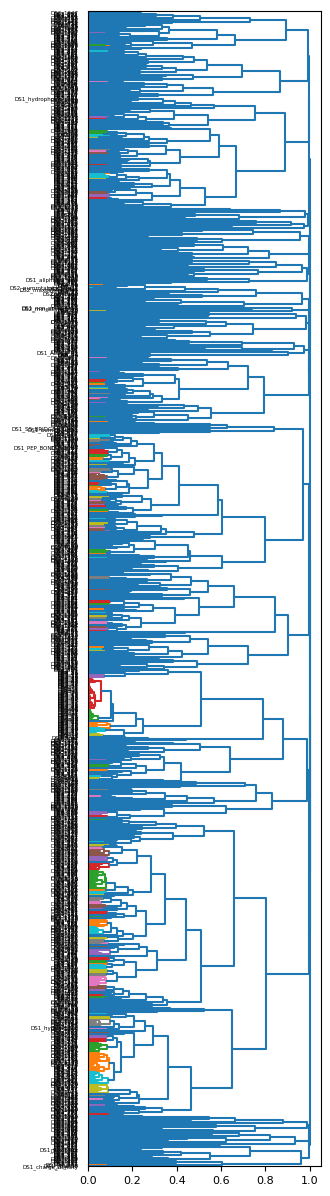

In [20]:

X_corr = pd.DataFrame(X_train_scaled,columns=X_train_scaled.columns).corr()
plt.figure(figsize=(3,15))
dissimilarity = 1 - abs(X_corr)
Z = linkage(squareform(dissimilarity), 'complete')
#Z = linkage(X_corr, 'complete')

dendrogram(Z, labels=X_train_scaled.columns, orientation='right', 
 leaf_rotation=0,color_threshold = 0.1);
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=8)
ax.tick_params(axis='y', which='major', labelsize=4)
#plt.savefig("/home/kyei/Project1/Figures/RF_DS124_Dendogram.png",bbox_inches = 'tight')

In [28]:

labels = fcluster(Z, 0.1, criterion='distance')
#plt.savefig("/home/kyei/Project1/Figures/Dendogram_DS1234_0_2.png")
Labels_pd = pd.DataFrame(pd.Series(X_train_scaled.columns),columns=["Features"])
Labels_pd["Cluster"] = labels
Dict_cluster = {k: g["Features"].tolist() for k,g in Labels_pd.groupby("Cluster")}



revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))


def grouped_shap(shap_vals, features, groups):
    '''
    Function to sum up shapvalues within highly correlated groups (ref: Scott Lundberg https://medium.com/@scottmlundberg/good-question-6229a343819f)
    '''
    
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    
    return shap_grouped


pandas_cluster = pd.DataFrame(pd.Series(Dict_cluster, name='Features'))
pandas_cluster['liststring'] = pandas_cluster['Features'].apply(lambda x: ','.join(map(str, x)))
pandas_cluster['liststring'] = pandas_cluster['liststring'].str.slice(0,50)

In [29]:
groupmap = revert_dict(Dict_cluster)
shap_Tdf = pd.DataFrame(X_test_scaled, columns=pd.Index(X_test_scaled.columns, name='features')).T
shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
pd_features_grouped = grouped_shap(X_test_scaled,X_test_scaled.columns,Dict_cluster)
pd_features_grouped.columns = pandas_cluster.liststring

In [ ]:
fig = plt.figure(figsize=(40, 20))
columns = 1
rows = 3
what_PK = 2
names = ["CL","T1-2","MRT"]
#plt.rcParams.update({'font.size': 10})
label_size = 10
for i in range(1, 4):
    fig.add_subplot(rows, columns, i)
    pd_cluster = pd.DataFrame(pandas_cluster['liststring'])
    shap_type = grouped_shap(shap_values[i-1], X_test_scaled.columns,Dict_cluster)
    shap_type.columns = pd_cluster["liststring"]
    newcmp = sns.color_palette("crest_r", as_cmap=True)
    
    #f = plt.figure()
    newcmp = sns.color_palette("crest_r", as_cmap=True)
    shap.summary_plot(shap_type.values, pd_features_grouped,feature_names = pd_features_grouped.columns,class_names =Y_train.columns ,max_display = 10,show=False,cmap=newcmp, plot_size = (10,10),color_bar_label='Feature value (sum)')
    #plt.savefig("/home/kyei/Project1/Figures/RF_DS124_shap_total.png",bbox_inches = 'tight')
    plt.gca().set_xlim(-0.6, 0.6)
    plt.gca().tick_params(axis='both', which='major', labelsize=label_size)
    plt.gcf().axes[-1].set_aspect(100)
    plt.gcf().axes[-1].set_box_aspect(100)
    plt.xlabel('xlabel', fontsize=label_size)
    #plt.figsize=(18, 40)
    plt.title("{}".format(names[i-1]),fontsize=label_size)
    plt.gca().set_xlabel('')
    if i % 3 == 0:
            plt.xlabel('xlabel', fontsize=label_size)
            plt.gca().tick_params(axis='both', which='major', labelsize=label_size)
            plt.gca().set_xlabel('SHAP values')
    
    
    
    #plt.show()
plt.savefig("../Figures/ANN_DS1234_shap_total.png",bbox_inches = 'tight')

# DS134

In [3]:
# Loop over test folds DS134
CV_folds_test_vivo = {}
for i in range(len(DS12_folds)): 
    print("=================BEGINNING FOLD {0} ==============".format(i+1))
    X_train, Y_train = DS1_folds[i][0].astype(np.float64),DS1_folds[i][3].astype(np.float32)  
    X_val,Y_val = DS1_folds[i][1].astype(np.float64),DS1_folds[i][4].astype(np.float32)
    X_test,Y_test = DS1_folds[i][2].astype(np.float64),DS1_folds[i][5].astype(np.float32)
    scaler_Y = pickle.load(open('../data/processed/Scaler_Y_{0}.pkl'.format(i),'rb'))
    
    X_train_seq = DS3_folds[i][0].astype(np.float64)
    X_train_seq.set_index(X_train.index,inplace = True)
    X_val_seq = DS3_folds[i][1].astype(np.float64)
    X_val_seq.set_index(X_val.index,inplace = True)
    X_test_seq = DS3_folds[i][2].astype(np.float64)
    X_test_seq.set_index(X_test.index,inplace = True)
    
    X_train_smiles = DS4_folds[i][0].astype(np.float64)
    X_train_smiles.set_index(X_train.index,inplace = True)
    X_val_smiles = DS4_folds[i][1].astype(np.float64)
    X_val_smiles.set_index(X_val.index,inplace = True)
    X_test_smiles = DS4_folds[i][2].astype(np.float64)
    X_test_smiles.set_index(X_test.index,inplace = True)
    
    dataset_train = Dataset_all_conc(X_train,X_train_seq,X_train_smiles,Y_train)
    dataset_val = Dataset_all_conc(X_val,X_val_seq,X_val_smiles,Y_val)
    dataset_test = Dataset_all_conc(X_test,X_test_seq,X_test_smiles,Y_test)
    
    # Hyper parameter optimization.
    study = optuna.create_study(direction="minimize",pruner=optuna.pruners.MedianPruner())
    study.optimize(lambda trial:objective_DS1234(trial,Data_train = dataset_train ,Data_Val = dataset_val ,
                                              Scaler_Y= scaler_Y,EPOCH=EPOCH,save_model=True,save_path = "../models/VIVO_FFNN_DS134_fold{0}.pt".format(i+1),
                                              input_dim_desc = X_train.shape[1]),
                                              n_trials = N_TRIALS)
    trial_ = study.best_trial
    with open('../models/Optuna_DS134_fold{0}.pkl'.format(i),'wb') as f:pickle.dump(trial_.params,f )
    print("Best hyperparameters for fold {0} is saved".format(i+1))
    print(f" best parameters for this fold {trial_.params}")
    best_params = pickle.load(open('../models/Optuna_DS134_fold{0}.pkl'.format(i),'rb'))
    
    # Build model using best hyperparameters:
    
    model = model_DS1234_build(best_params,input_dim_desc = X_train.shape[1], X_length_DS3 = 1280,X_length_DS4 = 100,stride_CNN = 1,
                 conv_dilation1 = 1,padding_DS3 = 0,padding_DS4 = 0, max_pool_kernel_size3 = 4)
    #model.load_state_dict(torch.load("/home/kyei/Project1/Model files/VIVO_FFNN_DS1234_fold{0}.pt".format(i+1)))
    
    # Train model (again) on best hyperparameters for train/val diagnostic plots:

    Vivo_train_results = train_and_validate(Params = best_params,Model = model,Data_train = dataset_train ,Data_Val = dataset_val,
                                            scaler_Y = scaler_Y,EPOCH = EPOCH,save_model = True,save_path = "../models/VIVO_FFNN_DS134_fold{0}.pt".format(i),
                                           trial = "None")
    
    
    # Make test set into dataloader:
    test_loader = DataLoader(dataset = dataset_test,batch_size=X_test.shape[0],shuffle=False,drop_last = True)
    
    # Use best model to evaluate on unseen test data:
    Vivo_test_results = test_FFNN(model,best_params, test_loader,scaler_Y = scaler_Y,save_path = "../models/VIVO_FFNN_DS134_fold{0}.pt".format(i),Y_data_for_index = Y_test)
   
    # Save each individual test output for each fold:
    with open("../models/Test_output_DS134_fold_{0}.pkl".format(i),'wb') as f:pickle.dump(Vivo_test_results,f )
    
    CV_folds_test_vivo[i] = Vivo_test_results
    
    model.apply(reset_weights)
    
with open("../data/processed/ANN_outer_5_test_DS134.pkl",'wb') as f:pickle.dump(CV_folds_test_vivo,f )

print("Completely done")

=================BEGINNING FOLD 1 ==============
Best hyperparameters for fold 1 is saved
 best parameters for this fold {'lr': 0.00017574467945233937, 'Batch_Size': 50, 'wd': 0.027263929620946516, 'conv1_filters_DS3': 28, 'conv2_filters_DS3': 23, 'conv1_filters_DS4': 3, 'conv2_filters_DS4': 6, 'Kernel_size1_DS3': 23, 'Kernel_size1_DS4': 6, 'dropout_FFNN_DS3': 0.5560043937732976, 'dropout_CNN_DS3': 0.2926739365775796, 'dropout_CNN_DS4': 0.5121743051413081, 'FC_after_CNN_DS3': 65, 'FC_after_CNN_DS4': 194, 'FC_After_DS12': 13, 'FC_Concatenation': 34}
=================BEGINNING FOLD 2 ==============
Best hyperparameters for fold 2 is saved
 best parameters for this fold {'lr': 2.0604288340000627e-06, 'Batch_Size': 58, 'wd': 0.08586043421143055, 'conv1_filters_DS3': 6, 'conv2_filters_DS3': 19, 'conv1_filters_DS4': 15, 'conv2_filters_DS4': 7, 'Kernel_size1_DS3': 19, 'Kernel_size1_DS4': 6, 'dropout_FFNN_DS3': 0.4723534965312115, 'dropout_CNN_DS3': 0.35266761856700457, 'dropout_CNN_DS4': 0.45

# DS34 using ANN

In [4]:
# Loop over test folds DS34
CV_folds_test_vivo = {}
for i in range(len(DS12_folds)): 
    print("=================BEGINNING FOLD {0} ==============".format(i+1))
    X_train, Y_train = DS1_folds[i][0].astype(np.float64),DS1_folds[i][3].astype(np.float32)  
    X_val,Y_val = DS1_folds[i][1].astype(np.float64),DS1_folds[i][4].astype(np.float32)
    X_test,Y_test = DS1_folds[i][2].astype(np.float64),DS1_folds[i][5].astype(np.float32)
    scaler_Y = pickle.load(open('../data/processed/Scaler_Y_{0}.pkl'.format(i),'rb'))
    
    ## Set all numeric entries to 0 (as we only have sequential data in this case). Ineffective but valid if we want to keep using the current framework and functions:
    X_train = pd.DataFrame(0.0, index=X_train.index, columns=X_train.columns)
    X_val = pd.DataFrame(0.0, index=X_val.index, columns=X_val.columns)
    X_test = pd.DataFrame(0.0, index=X_test.index, columns=X_test.columns)
    
    X_train_seq = DS3_folds[i][0].astype(np.float64)
    X_train_seq.set_index(X_train.index,inplace = True)
    X_val_seq = DS3_folds[i][1].astype(np.float64)
    X_val_seq.set_index(X_val.index,inplace = True)
    X_test_seq = DS3_folds[i][2].astype(np.float64)
    X_test_seq.set_index(X_test.index,inplace = True)
    
    X_train_smiles = DS4_folds[i][0].astype(np.float64)
    X_train_smiles.set_index(X_train.index,inplace = True)
    X_val_smiles = DS4_folds[i][1].astype(np.float64)
    X_val_smiles.set_index(X_val.index,inplace = True)
    X_test_smiles = DS4_folds[i][2].astype(np.float64)
    X_test_smiles.set_index(X_test.index,inplace = True)
    
    dataset_train = Dataset_all_conc(X_train,X_train_seq,X_train_smiles,Y_train)
    dataset_val = Dataset_all_conc(X_val,X_val_seq,X_val_smiles,Y_val)
    dataset_test = Dataset_all_conc(X_test,X_test_seq,X_test_smiles,Y_test)
    
    # Hyper parameter optimization.
    study = optuna.create_study(direction="minimize",pruner=optuna.pruners.MedianPruner())
    study.optimize(lambda trial:objective_DS1234(trial,Data_train = dataset_train ,Data_Val = dataset_val ,
                                              Scaler_Y= scaler_Y,EPOCH=EPOCH,save_model=True,save_path = "../models/VIVO_FFNN_DS34_fold{0}.pt".format(i+1),
                                              input_dim_desc = X_train.shape[1]),
                                              n_trials = N_TRIALS)
    trial_ = study.best_trial
    with open('../models/Optuna_DS34_fold{0}.pkl'.format(i),'wb') as f:pickle.dump(trial_.params,f )
    print("Best hyperparameters for fold {0} is saved".format(i+1))
    print(f" best parameters for this fold {trial_.params}")
    best_params = pickle.load(open('../models/Optuna_DS34_fold{0}.pkl'.format(i),'rb'))
    
    # Build model using best hyperparameters:
    
    model = model_DS1234_build(best_params,input_dim_desc = X_train.shape[1], X_length_DS3 = 1280,X_length_DS4 = 100,stride_CNN = 1,
                 conv_dilation1 = 1,padding_DS3 = 0,padding_DS4 = 0, max_pool_kernel_size3 = 4)
    #model.load_state_dict(torch.load("/home/kyei/Project1/Model files/VIVO_FFNN_DS1234_fold{0}.pt".format(i+1)))
    
    # Train model (again) on best hyperparameters for train/val diagnostic plots:
    Vivo_train_results = train_and_validate(Params = best_params,Model = model,Data_train = dataset_train ,Data_Val = dataset_val,
                                            scaler_Y = scaler_Y,EPOCH = EPOCH,save_model = True,save_path = "../models/VIVO_FFNN_DS34_fold{0}.pt".format(i),
                                           trial = "None")
    
    
    # Make test set into dataloader:
    test_loader = DataLoader(dataset = dataset_test,batch_size=X_test.shape[0],shuffle=False,drop_last = True)
    
    # Use best model to evaluate on unseen test data:
    Vivo_test_results = test_FFNN(model,best_params, test_loader,scaler_Y = scaler_Y,save_path = "../models/VIVO_FFNN_DS34_fold{0}.pt".format(i),Y_data_for_index = Y_test)
   
    # Save each individual test output for each fold:
    with open("../models/Test_output_DS34_fold_{0}.pkl".format(i),'wb') as f:pickle.dump(Vivo_test_results,f )
    
    CV_folds_test_vivo[i] = Vivo_test_results
    
    model.apply(reset_weights)
    
with open("../data/processed/ANN_outer_5_test_DS34.pkl",'wb') as f:pickle.dump(CV_folds_test_vivo,f )

print("Completely done")

=================BEGINNING FOLD 1 ==============
Best hyperparameters for fold 1 is saved
 best parameters for this fold {'lr': 2.940482496409609e-06, 'Batch_Size': 33, 'wd': 0.034606259713858334, 'conv1_filters_DS3': 21, 'conv2_filters_DS3': 26, 'conv1_filters_DS4': 3, 'conv2_filters_DS4': 10, 'Kernel_size1_DS3': 3, 'Kernel_size1_DS4': 15, 'dropout_FFNN_DS3': 0.0737123250868789, 'dropout_CNN_DS3': 0.020377695517726547, 'dropout_CNN_DS4': 0.27043722773516204, 'FC_after_CNN_DS3': 108, 'FC_after_CNN_DS4': 151, 'FC_After_DS12': 24, 'FC_Concatenation': 69}
=================BEGINNING FOLD 2 ==============
Best hyperparameters for fold 2 is saved
 best parameters for this fold {'lr': 0.0003400517758924616, 'Batch_Size': 57, 'wd': 0.07920217543349323, 'conv1_filters_DS3': 4, 'conv2_filters_DS3': 2, 'conv1_filters_DS4': 8, 'conv2_filters_DS4': 10, 'Kernel_size1_DS3': 3, 'Kernel_size1_DS4': 11, 'dropout_FFNN_DS3': 0.012671461175174592, 'dropout_CNN_DS3': 0.0688816248196495, 'dropout_CNN_DS4': 0

# DS234 using ANN

In [5]:
# Loop over test folds DS234
CV_folds_test_vivo = {}
for i in range(len(DS12_folds)): 
    print("=================BEGINNING FOLD {0} ==============".format(i+1))
    X_train, Y_train = DS2_folds[i][0].astype(np.float64),DS2_folds[i][3].astype(np.float32)  
    X_val,Y_val = DS2_folds[i][1].astype(np.float64),DS2_folds[i][4].astype(np.float32)
    X_test,Y_test = DS2_folds[i][2].astype(np.float64),DS2_folds[i][5].astype(np.float32)
    scaler_Y = pickle.load(open('../data/processed/Scaler_Y_{0}.pkl'.format(i),'rb'))
    
    X_train_seq = DS3_folds[i][0].astype(np.float64)
    X_train_seq.set_index(X_train.index,inplace = True)
    X_val_seq = DS3_folds[i][1].astype(np.float64)
    X_val_seq.set_index(X_val.index,inplace = True)
    X_test_seq = DS3_folds[i][2].astype(np.float64)
    X_test_seq.set_index(X_test.index,inplace = True)
    
    X_train_smiles = DS4_folds[i][0].astype(np.float64)
    X_train_smiles.set_index(X_train.index,inplace = True)
    X_val_smiles = DS4_folds[i][1].astype(np.float64)
    X_val_smiles.set_index(X_val.index,inplace = True)
    X_test_smiles = DS4_folds[i][2].astype(np.float64)
    X_test_smiles.set_index(X_test.index,inplace = True)
    
    dataset_train = Dataset_all_conc(X_train,X_train_seq,X_train_smiles,Y_train)
    dataset_val = Dataset_all_conc(X_val,X_val_seq,X_val_smiles,Y_val)
    dataset_test = Dataset_all_conc(X_test,X_test_seq,X_test_smiles,Y_test)
    
    # Hyper parameter optimization.
    study = optuna.create_study(direction="minimize",pruner=optuna.pruners.MedianPruner())
    study.optimize(lambda trial:objective_DS1234(trial,Data_train = dataset_train ,Data_Val = dataset_val ,
                                              Scaler_Y= scaler_Y,EPOCH=EPOCH,save_model=True,save_path = "../models/VIVO_FFNN_DS234_fold{0}.pt".format(i+1),
                                              input_dim_desc = X_train.shape[1]),
                                              n_trials = N_TRIALS)
    trial_ = study.best_trial
    with open('../models/Optuna_DS234_fold{0}.pkl'.format(i),'wb') as f:pickle.dump(trial_.params,f )
    print("Best hyperparameters for fold {0} is saved".format(i+1))
    print(f" best parameters for this fold {trial_.params}")
    best_params = pickle.load(open('../models/Optuna_DS234_fold{0}.pkl'.format(i),'rb'))
    
    # Build model using best hyperparameters:
    
    model = model_DS1234_build(best_params,input_dim_desc = X_train.shape[1], X_length_DS3 = 1280,X_length_DS4 = 100,stride_CNN = 1,
                 conv_dilation1 = 1,padding_DS3 = 0,padding_DS4 = 0, max_pool_kernel_size3 = 4)
    #model.load_state_dict(torch.load("/home/kyei/Project1/Model files/VIVO_FFNN_DS1234_fold{0}.pt".format(i+1)))
    
    # Train model (again) on best hyperparameters for train/val diagnostic plots:
    Vivo_train_results = train_and_validate(Params = best_params,Model = model,Data_train = dataset_train ,Data_Val = dataset_val,
                                            scaler_Y = scaler_Y,EPOCH = EPOCH,save_model = True,save_path = "../models/VIVO_FFNN_DS234_fold{0}.pt".format(i),
                                           trial = "None")
    
    
    # Make test set into dataloader:
    test_loader = DataLoader(dataset = dataset_test,batch_size=X_test.shape[0],shuffle=False,drop_last = True)
    
    # Use best model to evaluate on unseen test data:
    Vivo_test_results = test_FFNN(model,best_params, test_loader,scaler_Y = scaler_Y,save_path = "../models/VIVO_FFNN_DS234_fold{0}.pt".format(i),Y_data_for_index = Y_test)
   
    # Save each individual test output for each fold:
    with open("../models/Test_output_DS234_fold_{0}.pkl".format(i),'wb') as f:pickle.dump(Vivo_test_results,f )
    
    CV_folds_test_vivo[i] = Vivo_test_results
    
    model.apply(reset_weights)
    
with open("../data/processed/ANN_outer_5_test_DS234.pkl",'wb') as f:pickle.dump(CV_folds_test_vivo,f )

print("Completely done")

=================BEGINNING FOLD 1 ==============
Best hyperparameters for fold 1 is saved
 best parameters for this fold {'lr': 1.7620942244309723e-06, 'Batch_Size': 51, 'wd': 0.09207483324009177, 'conv1_filters_DS3': 2, 'conv2_filters_DS3': 20, 'conv1_filters_DS4': 11, 'conv2_filters_DS4': 10, 'Kernel_size1_DS3': 20, 'Kernel_size1_DS4': 3, 'dropout_FFNN_DS3': 0.12215512503212575, 'dropout_CNN_DS3': 0.23511278238485106, 'dropout_CNN_DS4': 0.00819339520999711, 'FC_after_CNN_DS3': 90, 'FC_after_CNN_DS4': 216, 'FC_After_DS12': 19, 'FC_Concatenation': 87}
=================BEGINNING FOLD 2 ==============
Best hyperparameters for fold 2 is saved
 best parameters for this fold {'lr': 1.7729945301510894e-06, 'Batch_Size': 35, 'wd': 0.0882249421627763, 'conv1_filters_DS3': 29, 'conv2_filters_DS3': 22, 'conv1_filters_DS4': 4, 'conv2_filters_DS4': 15, 'Kernel_size1_DS3': 9, 'Kernel_size1_DS4': 15, 'dropout_FFNN_DS3': 0.3789830351885246, 'dropout_CNN_DS3': 0.09911127178808112, 'dropout_CNN_DS4': 0